# Tworzenie maski Corine Land Cover

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.warp import reproject, Resampling

from bands.basic_processing import BandProcessor
from bands.display import show_band_index, display_parameters
from bands.load import LoadBands
from reproject_raster import reproject_raster
from save_data import SaveToTiff, save_resampled_image

In [2]:
CLC_IMAGE = './data/clip_clc.tif'  # korzystamy już z przyciętych danych do naszego obszaru
SAMPLE_IMAGE = './data/clip_S2B_MSIL1C_20200914T095029_N0209_R079_T34UDC_20200914T111045_B02.tif'  # wybrany kanał
CLC_META = './data/clc_legend.csv'  # legenda do Corine Land Cover

Przyjrzyjmy się danym satelitarnym i podstawowym informacjom na ich temat.

In [3]:
band, crs, transform = display_parameters(SAMPLE_IMAGE)
print(f'Crs: {crs}, \nTransform: \n{transform}')

Crs: EPSG:32634, 
Transform: 
| 10.00, 0.00, 485920.00|
| 0.00,-10.00, 5797930.00|
| 0.00, 0.00, 1.00|


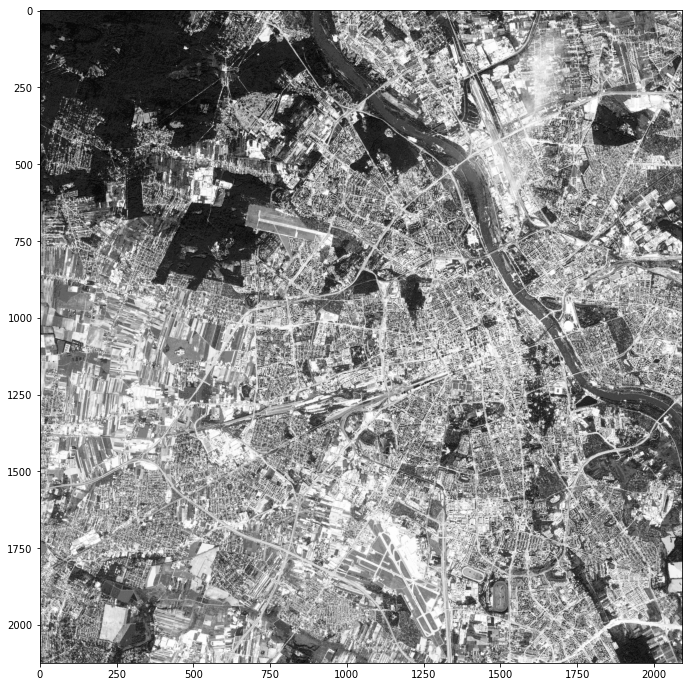

In [4]:
BandProcessor(band).show_processed_bands()

Wyświetlmy również dane dla obrazu Corine Land Cover

In [5]:
clc_band, clc_crs, clc_transform = display_parameters(CLC_IMAGE)
print(f'Crs: {clc_crs}, \nTransform: \n{clc_transform}')

Crs: EPSG:3035, 
Transform: 
| 250.00, 0.00, 5053500.00|
| 0.00,-250.00, 3304750.00|
| 0.00, 0.00, 1.00|


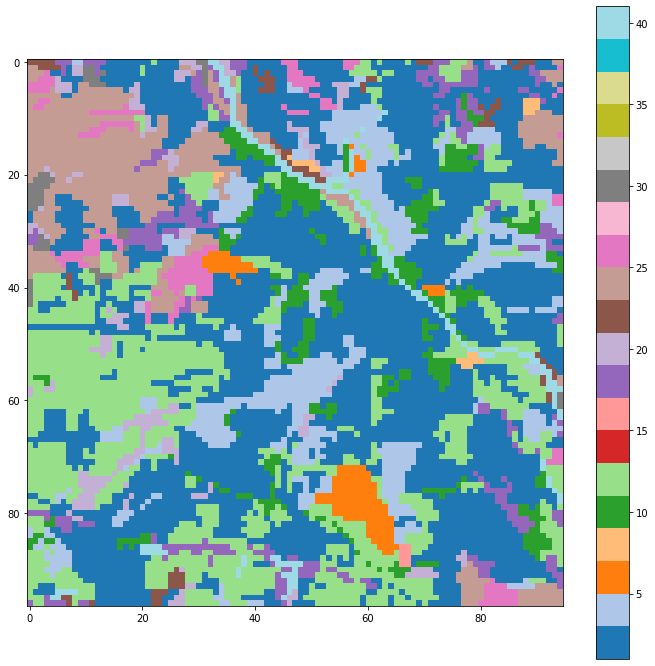

In [6]:
show_band_index(clc_band, normalize=False, cmap='tab20', cbar=True)

Nasz problem jest taki, że projekcja w obu przypadkach różni się i trudno przygotować wsad do uczenia maszynowego z takich danych! Musimy dokonać reprojekcji. Zrobimy to przy pomocy metody `reproject` z paczki `rasterio`. Metoda ta przyjmuje dużo parametrów, które musimy wypełnić. Są to:

- kanał, który będzie poddany projekcji,
- plik, do którego zapisany zostanie nowy obraz,
- informacje o zasięgu i pikselach źródła,
- informacja o CRS źródła,
- informacje o docelowym zasięgu i wielkości pikseli,
- informacja o docelowym CRS,
- sposób przetwarzania.

Właściwie wszystkie informacje pobraliśmy z naszych plików. Jedynie sposób przetwarzania musi być wybrany inaczej. Ze względu na to, że pracujemy z Corine Land Cover, gdzie wartości całkowite opisują obszar, nie możemy wybrać interpolacji pikseli przy użyciu średniej i podobnych metod. Wybieramy więc **modalną** pikseli poddanych przekształceniu.

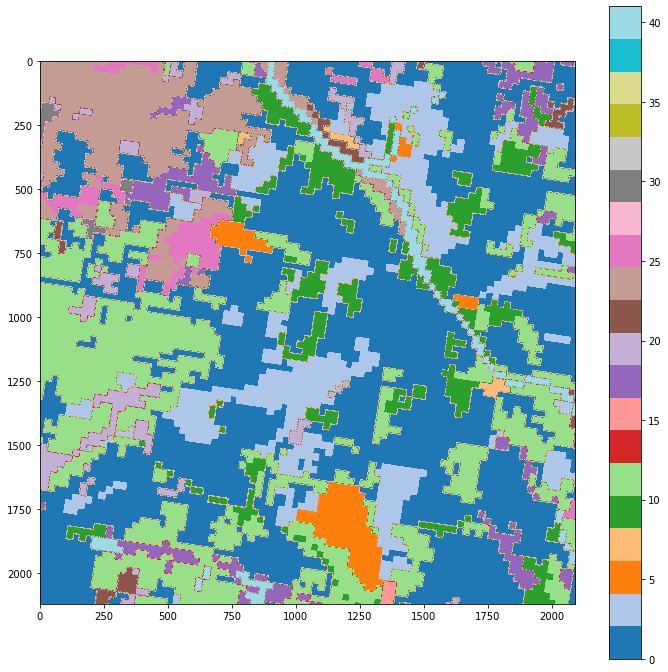

In [7]:
clc_reprojected = reproject_raster(clc_band,
                                   clc_transform,
                                   clc_crs,
                                   band,
                                   transform,
                                   crs)
show_band_index(clc_reprojected, normalize=False, cmap='tab20', cbar=True)

Zapisujemy plik po resamplingu

In [8]:
save_resampled_image(clc_reprojected, crs, transform, './results/resampled_clc.tif')

Przetworzenie zostanie przeprowadzone na podstawie legendy Corine Land Cover. Legenda zapisana jest do pliku csv. Wczytamy ją i odpowiednio przygotujemy.

In [14]:
df = pd.read_csv(CLC_META, sep=';')
df.head()

,GRID_CODE,CLC_CODE,LABEL3,RGB
0,1,111,Continuous urban fabric,230-000-077
1,2,112,Discontinuous urban fabric,255-000-000
2,3,121,Industrial or commercial units,204-077-242
3,4,122,Road and rail networks and associated land,204-000-000
4,5,123,Port areas,230-204-204


Wyznaczamy wartości unikalne

In [16]:
uniques = [int(x) for x in np.unique(clc_reprojected)]
df_unique = df[df['GRID_CODE'].isin(uniques)]
df_unique

,GRID_CODE,CLC_CODE,LABEL3,RGB
0,1,111,Continuous urban fabric,230-000-077
1,2,112,Discontinuous urban fabric,255-000-000
2,3,121,Industrial or commercial units,204-077-242
3,4,122,Road and rail networks and associated land,204-000-000
4,5,123,Port areas,230-204-204
5,6,124,Airports,230-204-230
7,8,132,Dump sites,166-077-000
8,9,133,Construction sites,255-077-255
9,10,141,Green urban areas,255-166-255
10,11,142,Sport and leisure facilities,255-230-255


Jak widać, pierwsze osiem rekordów to typowo industrialne obiekty a pozostałe nie są stworzone przez człowieka. W ten sposób możemy stworzyć słownik wartości binarnych, które przypiszemy w zależności od wartości GRID_CODE.

In [23]:
df_unique['BIN_CODE'] = df_unique['GRID_CODE'].apply(lambda x: 1 if x < 10 else 0)
df_unique

C:\Users\Marta\AppData\Local\Temp\ipykernel_12780\4220556891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['BIN_CODE'] = df_unique['GRID_CODE'].apply(lambda x: 1 if x < 10 else 0)


,GRID_CODE,CLC_CODE,LABEL3,RGB,BIN_CODE
0,1,111,Continuous urban fabric,230-000-077,1
1,2,112,Discontinuous urban fabric,255-000-000,1
2,3,121,Industrial or commercial units,204-077-242,1
3,4,122,Road and rail networks and associated land,204-000-000,1
4,5,123,Port areas,230-204-204,1
5,6,124,Airports,230-204-230,1
7,8,132,Dump sites,166-077-000,1
8,9,133,Construction sites,255-077-255,1
9,10,141,Green urban areas,255-166-255,0
10,11,142,Sport and leisure facilities,255-230-255,0


Na podobnej zasadzie jak stworzyliśmy kolumnę `BIN_CODE` możemy dokonać transformacji obrazu `numpy`.

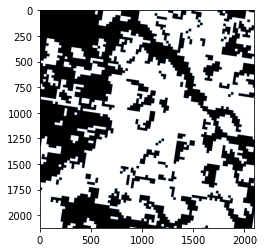

In [25]:
binarized = clc_reprojected.copy()
binarized[binarized < 10] = 1
binarized[binarized >= 10] = 0
plt.imshow(binarized, cmap='bone');

Sprawdźmy jeszcze balans między klasami:

In [28]:
urban_class = binarized.mean() * 100
print(f'{urban_class:.2f}% próbek należy do klasy reprezentującej obszar zurbanizowany;',
    f'\n{100-urban_class:.2f}% próbek należy do obszarów niezurbanizowanych.')

58.61% próbek należy do klasy reprezentującej obszar zurbanizowany; 
41.39% próbek należy do obszarów niezurbanizowanych.


Zapisujemy do pliku binarkę

In [29]:
save_resampled_image(binarized, crs, transform, './results/binarized_clc.tif')